In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.constants import speed_of_light
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.interpolate import RegularGridInterpolator as RGI
from configparser import ConfigParser
from numba import njit

from lya_2pt.tracer import Tracer
from lya_2pt.tracer_utils import get_angle
from lya_2pt.interface import Interface
import lya_2pt.global_data as globals
import lya_2pt.optimal_estimator as optest

from astropy.io import fits
import fitsio

In [2]:
config = ConfigParser()
config.read('configs/lyaxlya_cf.ini')
lya2pt = Interface(config)
lya2pt.read_tracers()

Om=0.315, Or=7.963219132297603e-05, wl=-1.0


In [4]:
# globals.tracers1[1952][0].ne

In [3]:
# lya2pt.run()

In [7]:
2.25 * 60 / 72

1.875

In [6]:
lya2pt.optimal_xi_output

{1952: (array([  0.        , 376.35164424, 136.20727796, ...,   0.        ,
           0.        ,   0.        ]),
  array([[    0.       ,     0.       ,     0.       , ...,     0.       ,
              0.       ,     0.       ],
         [    0.       , 70827.6606944,     0.       , ...,     0.       ,
              0.       ,     0.       ],
         [    0.       ,     0.       , 94121.9112909, ...,     0.       ,
              0.       ,     0.       ],
         ...,
         [    0.       ,     0.       ,     0.       , ...,     0.       ,
              0.       ,     0.       ],
         [    0.       ,     0.       ,     0.       , ...,     0.       ,
              0.       ,     0.       ],
         [    0.       ,     0.       ,     0.       , ...,     0.       ,
              0.       ,     0.       ]])),
 1953: (array([ 385.19109078,  300.78531507, 1116.33647964, ...,    0.        ,
            0.        ,    0.        ]),
  array([[6.51257958e+04, 0.00000000e+00, 0.0000000

In [4]:
xi1d_interp = optest.build_xi1d()

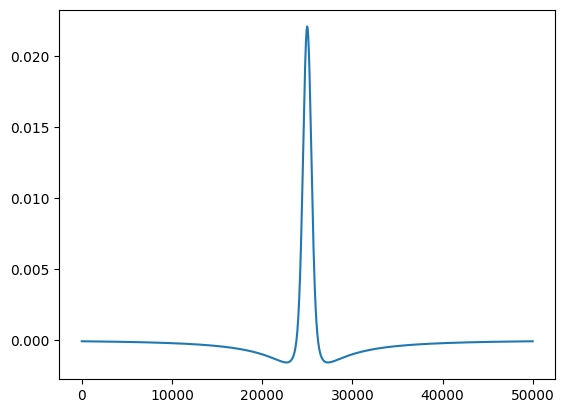

In [5]:
plt.plot(xi1d_interp((1.8, np.linspace(-100, 100, 50000))))

In [6]:
healpix_id = 1952
hp_neighs = [other_hp for other_hp in globals.healpix_neighbours[healpix_id]
             if other_hp in globals.tracers2]
hp_neighs += [healpix_id]

In [7]:
tracer1 = globals.tracers1[healpix_id][0]
potential_neighbours = [tracer2 for hp in hp_neighs for tracer2 in globals.tracers2[hp]]
neighbours = tracer1.get_neighbours(
    potential_neighbours, globals.auto_flag,
    globals.z_min, globals.z_max,
    globals.rp_max, globals.rt_max
    )
tracer2 = neighbours[0]

angle = get_angle(tracer1.x_cart, tracer1.y_cart, tracer1.z_cart, tracer1.ra, tracer1.dec,
                  tracer2.x_cart, tracer2.y_cart, tracer2.z_cart, tracer2.ra, tracer2.dec)

In [8]:
total_size = int(globals.num_bins_rp * globals.num_bins_rt)

xi_est = np.zeros(total_size)
fisher_est = np.zeros((total_size, total_size))

In [10]:
optest.compute_xi_and_fisher_pair(tracer1, tracer2, angle, xi1d_interp, xi_est, fisher_est)

(array([  0.        ,   0.        , -16.59657238, ...,   0.        ,
          0.        ,   0.        ]),
 array([[   0.       ,    0.       ,    0.       , ...,    0.       ,
            0.       ,    0.       ],
        [   0.       ,    0.       ,    0.       , ...,    0.       ,
            0.       ,    0.       ],
        [   0.       ,    0.       , 6188.3171725, ...,    0.       ,
            0.       ,    0.       ],
        ...,
        [   0.       ,    0.       ,    0.       , ...,    0.       ,
            0.       ,    0.       ],
        [   0.       ,    0.       ,    0.       , ...,    0.       ,
            0.       ,    0.       ],
        [   0.       ,    0.       ,    0.       , ...,    0.       ,
            0.       ,    0.       ]]))

Text(0, 0.5, '$r_{||}$')

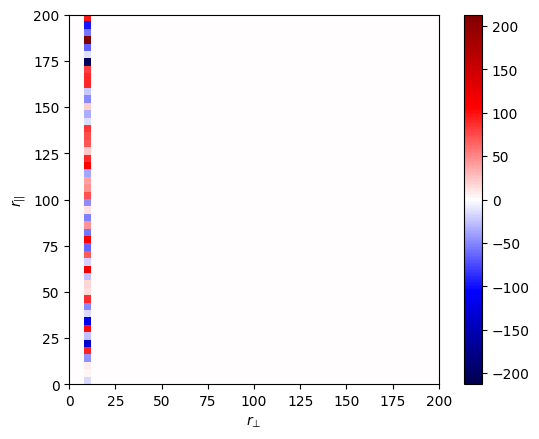

In [11]:
plt.imshow(xi_est.reshape(50, 50), origin='lower', cmap='seismic',
           vmin=-xi_est.max(), vmax=xi_est.max(),
           extent=(0, 200, 0, 200))
plt.colorbar()
plt.xlabel(r'$r_\bot$')
plt.ylabel(r'$r_{||}$')

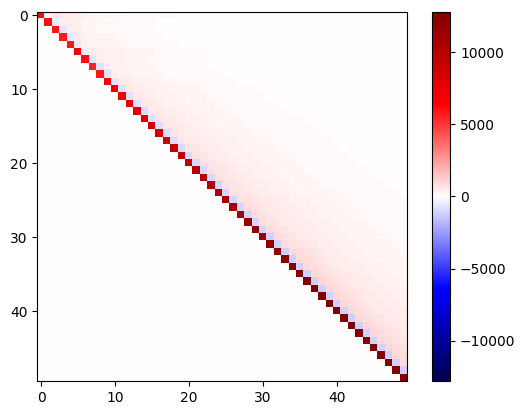

In [12]:
plt.imshow(fisher_est[2::50, 2::50], vmin=-fisher_est[2::50, 2::50].max(), vmax=fisher_est[2::50, 2::50].max(),
           cmap='seismic')
plt.colorbar()
# plt.xlabel(r'$r_\bot$')
# plt.ylabel(r'$r_{||}$')

In [22]:
np.sum(fisher_est)

205219.62005940845

In [14]:
%%timeit -n 10
optest.compute_xi_and_fisher_pair(tracer1, tracer2, angle, xi1d_interp, xi_est, fisher_est)

939 ms ± 386 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
def compute_xi_and_fisher_pair(
        tracer1, tracer2, angle, xi1d_interp,
        xi_est, fisher_est
):
    invcov1 = build_inverse_covariance(tracer1, xi1d_interp)
    invcov2 = build_inverse_covariance(tracer2, xi1d_interp)

    bins, mask = get_xi_bins(tracer1, tracer2, angle)
    c_deriv_dict = build_deriv(xi_est.size, bins)

    for key1, c_deriv1 in c_deriv_dict.items():
        xi = c_deriv1.dot(invcov2 @ tracer2.deltas)
        xi = 2 * np.dot(invcov1 @ tracer1.deltas, xi)

        xi_est[key1] += xi

        c1_inv_times_c_deriv = c_deriv1.dot(invcov2)

        for i, (key2, c_deriv2) in enumerate(c_deriv_dict.items()):
            if key2 < key1:
                continue
            # c2_inv_times_c_deriv = c_deriv2.T.dot(invcov1)
            c2_inv_times_c_deriv = invcov1 @ c_deriv2

            fisher_est[key1, key2] += np.vdot(c1_inv_times_c_deriv, c2_inv_times_c_deriv)

    return xi_est, fisher_est

In [15]:
# %%timeit -n 10
optest.compute_xi_and_fisher_pair(tracer1, tracer2, angle, xi1d_interp, xi_est, fisher_est)

(array([    0.        ,     0.        , -1194.95321115, ...,
            0.        ,     0.        ,     0.        ]),
 array([[     0.        ,      0.        ,      0.        , ...,
              0.        ,      0.        ,      0.        ],
        [     0.        ,      0.        ,      0.        , ...,
              0.        ,      0.        ,      0.        ],
        [     0.        ,      0.        , 445558.83642036, ...,
              0.        ,      0.        ,      0.        ],
        ...,
        [     0.        ,      0.        ,      0.        , ...,
              0.        ,      0.        ,      0.        ],
        [     0.        ,      0.        ,      0.        , ...,
              0.        ,      0.        ,      0.        ],
        [     0.        ,      0.        ,      0.        , ...,
              0.        ,      0.        ,      0.        ]]))

In [17]:
invcov1 = optest.build_inverse_covariance(tracer1, xi1d_interp)
invcov2 = optest.build_inverse_covariance(tracer2, xi1d_interp)

bins, mask = optest.get_xi_bins(tracer1, tracer2, angle)
c_deriv_dict = optest.build_deriv(xi_est.size, bins)

c_deriv1 = c_deriv_dict[2]
c1_inv_times_c_deriv = c_deriv1.dot(invcov2)
c_deriv2 = c_deriv_dict[52]

NameError: name 'build_inverse_covariance' is not defined

In [16]:
%%timeit
c2_inv_times_c_deriv = invcov1 @ c_deriv2
fisher_est[key1, key2] += np.vdot(c1_inv_times_c_deriv, c2_inv_times_c_deriv)

NameError: name 'invcov1' is not defined

In [14]:
invcov1 = optest.build_inverse_covariance(tracer1, xi1d_interp)
invcov2 = optest.build_inverse_covariance(tracer2, xi1d_interp)

bins, mask = optest.get_xi_bins(tracer1, tracer2, angle)
c_deriv_dict = optest.build_deriv(xi_est.size, bins)

xi_est = np.zeros(total_size)
fisher_est = np.zeros((total_size, total_size))
for key1, c_deriv1 in c_deriv_dict.items():
    xi = c_deriv1.dot(invcov2 @ tracer2.deltas)
    xi = 2 * np.dot(invcov1 @ tracer1.deltas, xi)

    xi_est[key1] += xi

    c1_inv_times_c_deriv = c_deriv1.dot(invcov2)

    for key2, c_deriv2 in c_deriv_dict.items():
        c2_inv_times_c_deriv = c_deriv2.T.dot(invcov1)

        fisher_est[key1, key2] += np.vdot(c1_inv_times_c_deriv, c2_inv_times_c_deriv.T)


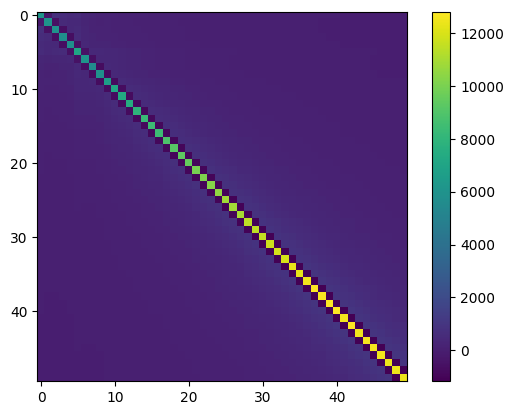

In [47]:
plt.imshow(fisher_est[2::50, 2::50])
plt.colorbar()
# plt.xlabel(r'$r_\bot$')
# plt.ylabel(r'$r_{||}$')

In [50]:
%%timeit
bins, mask = optest.get_xi_bins(tracer1, tracer2, angle)

156 µs ± 11.2 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [54]:
%%timeit
invcov1 = optest.build_inverse_covariance(tracer1, xi1d_interp)

11.4 ms ± 3.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [56]:
%%timeit
invcov2 = optest.build_inverse_covariance(tracer2, xi1d_interp)

3.11 ms ± 1.82 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [60]:
%%timeit
c_deriv_dict = optest.build_deriv(xi_est.size, bins)

6.06 ms ± 211 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [67]:
len(c_deriv_dict.keys())

50

In [73]:
c_deriv_dict.keys()

dict_keys([2, 52, 102, 152, 202, 252, 302, 352, 402, 452, 502, 552, 602, 652, 702, 752, 802, 852, 902, 952, 1002, 1052, 1102, 1152, 1202, 1252, 1302, 1352, 1402, 1452, 1502, 1552, 1602, 1652, 1702, 1752, 1802, 1852, 1902, 1952, 2002, 2052, 2102, 2152, 2202, 2252, 2302, 2352, 2402, 2452])

In [70]:
c_deriv1 = c_deriv_dict[2]

In [71]:
%%timeit
xi = c_deriv1.dot(invcov2 @ tracer2.deltas)
xi = 2 * np.dot(invcov1 @ tracer1.deltas, xi)
xi_est[key1] += xi

64.3 µs ± 9.19 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [69]:
%%timeit
c1_inv_times_c_deriv = c_deriv1.dot(invcov2)

17.5 µs ± 940 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [23]:
64 * 50 / 1000

3.2

In [15]:
c_deriv2 = c_deriv_dict[52]

In [16]:
%%timeit
c2_inv_times_c_deriv = c_deriv2.T.dot(invcov1)

35.1 µs ± 1.97 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [17]:
50*51/2

1275.0

In [18]:
30 * 1275 / 1000

38.25

In [20]:
%%timeit
fisher_est[key1, key2] += np.vdot(c1_inv_times_c_deriv, c2_inv_times_c_deriv.T)

73 µs ± 12.8 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [21]:
73 * 1275 / 1000

93.075

In [42]:
test_1 = np.vdot(c1_inv_times_c_deriv, c2_inv_times_c_deriv)
test_2 = np.vdot(c1_inv_times_c_deriv, c2_inv_times_c_deriv.T)

In [57]:
11/800

0.01375

In [45]:
test_2.shape

()

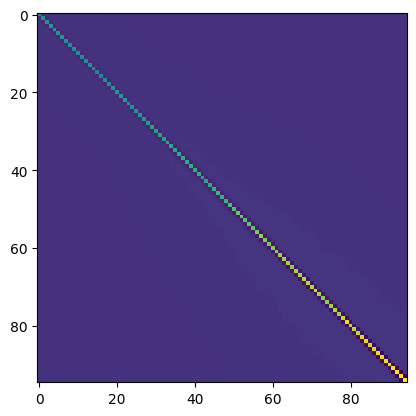

In [36]:
plt.imshow(invcov2)

In [32]:
tracer2.z.size

95